<a href="https://colab.research.google.com/github/IEwaspbusters/KopuruVespaCompetitionIE/blob/main/Competition_subs/2021-04-28_submit/batch_LARVAE/HEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost Years: Prediction per Cluster with selected Weather Variables (according to Feature importance)

## Import the Data & Modules

In [324]:
# Base packages -----------------------------------
import pandas as pd
import numpy as np

# Data Viz -----------------------------------
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10) # to set figure size when ploting feature_importance


# XGBoost -------------------------------
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance # built-in function to plot features ordered by their importance

# SKLearn -----------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn import preprocessing # scaling data

In [443]:
def check_data(HEX):
    
    def template_checker(HEX):
        submission_df = (HEX["CODIGO MUNICIPIO"].astype("string")+HEX["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        template_df = (template["CODIGO MUNICIPIO"].astype("string")+template["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        check_df = pd.DataFrame({"submission_df":submission_df,"template_df":template_df})
        check_df["check"] = check_df.submission_df == check_df.template_df
        if (check_df.check == False).any():
            pd.options.display.max_rows = 112
            return check_df.loc[check_df.check == False,:]
        else:  
            return "All Municipality Names and Codes to be submitted match the Template"
    
    print("Submission form Shape is", HEX.shape)
    print("Number of Municipalities is", HEX["CODIGO MUNICIPIO"].nunique())
    print("The Total 2020 Nests' Prediction is", int(HEX["NIDOS 2020"].sum()))

    assert HEX.shape == (112, 3), "Error: Shape is incorrect."
    assert HEX["CODIGO MUNICIPIO"].nunique() == 112, "Error: Number of unique municipalities is correct."    
    return template_checker(HEX)

In [456]:
# Importing datasets from GitHub as Pandas Dataframes
queen_train = pd.read_csv("../Feeder_years/WBds03_QUEENtrain_years.csv", encoding="utf-8") #2018+2019 test df
queen_predict = pd.read_csv("../Feeder_years/WBds03_QUEENpredict_years.csv", encoding="utf-8") #2020 prediction df
queen_predict.municip_name = queen_predict.municip_name.str.replace("Ã±","ñ").str.replace("Ã©","é").str.replace("Ã¡","á").str.replace("Ã¼","ü") # replace encoding characters that raise problems
queen_clusters = pd.read_csv("../../../Other_open_data/cluster.csv",sep=",", encoding="utf-8")
template = pd.read_csv("../../../Input_open_data/ds01_PLANTILLA-RETO-AVISPAS-KOPURU.csv",sep=";", encoding="utf-8")

## Further Clean the Data

In [542]:
# Remove the Municipalities that we did not assign a Cluster since there was not reliable data for us to predict 

queen_train = queen_train.loc[~queen_train.municip_code.isin([48071, 48074, 48022, 48088, 48051, 48020]),:]
queen_predict = queen_predict.loc[~queen_predict.municip_code.isin([48071, 48074, 48022, 48088, 48051, 48020]),:]

# Filter the Municipalities by clusters in order to apply the models to each cluster

queen_cluster_dict = {}
for i in range(0,4,1):
    queen_cluster_dict["queen_cluster{0}".format(i+1)] = (queen_clusters.loc[queen_clusters.Cluster == i, "CODIGO MUNICIPIO"].to_list())

## Get the Prediction for: Cluster 1 

### Arrange data into a features matrix and target vector

In [536]:
# selecting the train X & y variables

queen_train_cluster1 = queen_train.loc[queen_train.municip_code.isin(queen_cluster_dict.get("queen_cluster1")),:] 
queen_predict_cluster1 = queen_predict.loc[queen_predict.municip_code.isin(queen_cluster_dict.get("queen_cluster1")),:] 

# Y will be the response variable (filter for the number of wasp nests - waspbust_id)  
y_cluster1 = queen_train_cluster1.waspbust_id

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X_cluster1 = queen_train_cluster1.iloc[:,6:].drop("station_code",axis=1)

# We want to predict our response variable (number of nests in 2020). Remove response variable and non desired categorical columns such as (municip code, year, etc...)
queen_predict2020_cluster1 = queen_predict_cluster1.iloc[:,5:].drop("station_code",axis=1)

### Scale the Data in order to filter the relevant variables using Feature Importance

#### Arrange data into a features matrix and target vector

In [459]:
# Scale the datasets using MinMaxScaler

X_scaled_cluster1 = preprocessing.minmax_scale(X_cluster1) # this creates a numpy array
X_scaled_cluster1 = pd.DataFrame(X_scaled_cluster1,index=X_cluster1.index,columns=X_cluster1.columns) # create a Pandas DF==X

#### Choose a class of model by importing the appropriate estimator class

In [460]:
# selecting the XGBoost model and fitting with the train data
model_cluster1 = XGBRegressor()

#### Fit the model to your data by calling the `.fit()` method of the model instance

In [461]:
model_cluster1.fit(X_scaled_cluster1, y_cluster1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Selecting the Relevant Variables and filtering according to the results

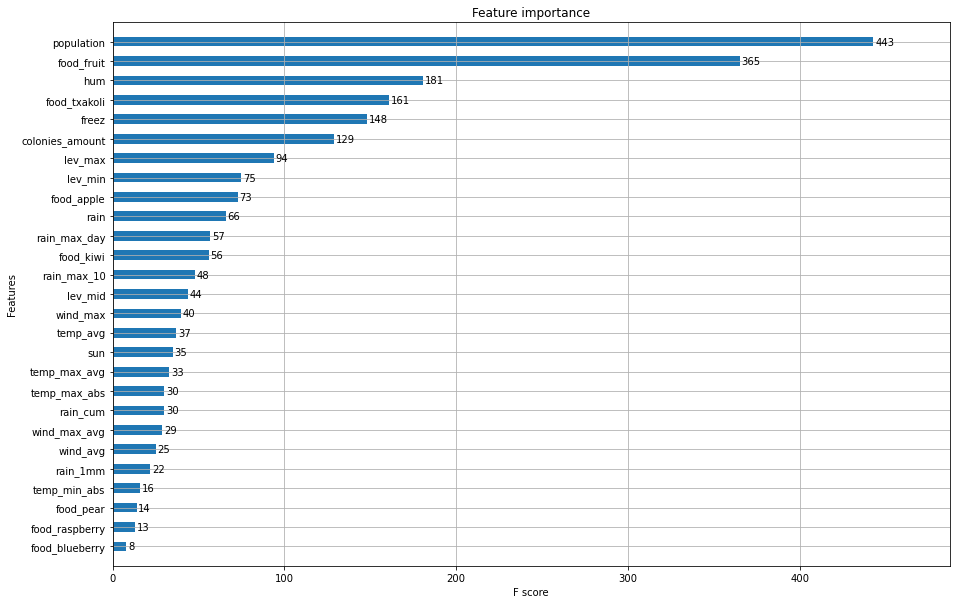

In [462]:
# plot feature importance to select relevant variables

plot_importance(model_cluster1,height=0.5)
plt.show()

In [463]:
# selecting the XGBoost model and fitting with the train data without the irrelevant variables
# selecting the train X & y variables

# Y will be the response variable (filter for the number of wasp nests - waspbust_id)  
y_cluster1 = queen_train_cluster1.waspbust_id

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X_cluster1 = queen_train_cluster1.iloc[:,6:].loc[:,["population","food_fruit","hum"]]

# We want to predict our response variable (number of nests in 2020). Remove response variable and non desired categorical columns such as (municip code, year, etc...)
queen_predict2020_cluster1 = queen_predict_cluster1.iloc[:,5:].loc[:,["population","food_fruit","hum"]]

### Choose a class of model by importing the appropriate estimator class

In [464]:
# refitting the model

model_cluster1 = XGBRegressor()

### Fit the model to your data by calling the `.fit()` method of the model instance

In [465]:
model_cluster1.fit(X_cluster1, y_cluster1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Apply the model to new data:

- For supervised learning, predict labels for unknown data using the `.predict()` method

In [466]:
# make a prediction

prediction_2020_cluster1 = model_cluster1.predict(queen_predict2020_cluster1)

C:\Users\pgeir\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [467]:
# the number of nests so we can compare between us
print(prediction_2020_cluster1.sum())

1719.2769


## Get the Prediction for: Cluster 2

### Arrange data into a features matrix and target vector

In [537]:
# selecting the train X & y variables

queen_train_cluster2 = queen_train.loc[queen_train.municip_code.isin(queen_cluster_dict.get("queen_cluster2")),:] 
queen_predict_cluster2 = queen_predict.loc[queen_predict.municip_code.isin(queen_cluster_dict.get("queen_cluster2")),:] 

# Y will be the response variable (filter for the number of wasp nests - waspbust_id)  
y_cluster2 = queen_train_cluster2.waspbust_id

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X_cluster2 = queen_train_cluster2.iloc[:,6:].drop("station_code",axis=1)

# We want to predict our response variable (number of nests in 2020). Remove response variable and non desired categorical columns such as (municip code, year, etc...)
queen_predict2020_cluster2 = queen_predict_cluster2.iloc[:,5:].drop("station_code",axis=1)

### Scale the Data in order to filter the relevant variables using Feature Importance

#### Arrange data into a features matrix and target vector

In [469]:
# Scale the datasets using MinMaxScaler

X_scaled_cluster2 = preprocessing.minmax_scale(X_cluster2) # this creates a numpy array
X_scaled_cluster2 = pd.DataFrame(X_scaled_cluster2,index=X_cluster2.index,columns=X_cluster2.columns) # create a Pandas DF==X

#### Choose a class of model by importing the appropriate estimator class

In [470]:
# selecting the XGBoost model and fitting with the train data
model_cluster2 = XGBRegressor()

#### Fit the model to your data by calling the `.fit()` method of the model instance

In [471]:
model_cluster2.fit(X_scaled_cluster2, y_cluster2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Selecting the Relevant Variables and filtering according to the results

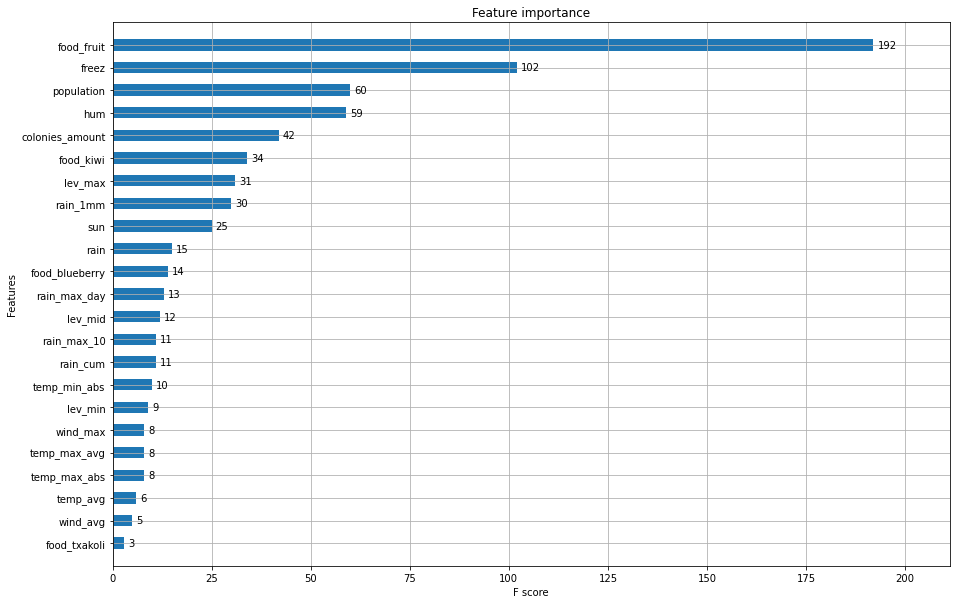

In [472]:
# plot feature importance to select relevant variables

plot_importance(model_cluster2,height=0.5)
plt.show()

In [473]:
# selecting the XGBoost model and fitting with the train data without the irrelevant variables
# selecting the train X & y variables

# Y will be the response variable (filter for the number of wasp nests - waspbust_id)  
y_cluster2 = queen_train_cluster2.waspbust_id

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X_cluster2 = queen_train_cluster2.iloc[:,6:].loc[:,["food_fruit","freez"]]

# We want to predict our response variable (number of nests in 2020). Remove response variable and non desired categorical columns such as (municip code, year, etc...)
queen_predict2020_cluster2 = queen_predict_cluster2.iloc[:,5:].loc[:,["food_fruit","freez"]]

### Choose a class of model by importing the appropriate estimator class

In [474]:
# refitting the model

model_cluster2 = XGBRegressor()

### Fit the model to your data by calling the `.fit()` method of the model instance

In [475]:
model_cluster2.fit(X_cluster2, y_cluster2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Apply the model to new data:

- For supervised learning, predict labels for unknown data using the `.predict()` method

In [476]:
# make a prediction

prediction_2020_cluster2 = model_cluster2.predict(queen_predict2020_cluster2)

C:\Users\pgeir\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [477]:
# the number of nests so we can compare between us
print(prediction_2020_cluster2.sum())

984.9159


## Get the Prediction for: Cluster 3

### Arrange data into a features matrix and target vector

In [538]:
# selecting the train X & y variables

queen_train_cluster3 = queen_train.loc[queen_train.municip_code.isin(queen_cluster_dict.get("queen_cluster3")),:] 
queen_predict_cluster3 = queen_predict.loc[queen_predict.municip_code.isin(queen_cluster_dict.get("queen_cluster3")),:] 

# Y will be the response variable (filter for the number of wasp nests - waspbust_id)  
y_cluster3 = queen_train_cluster3.waspbust_id

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X_cluster3 = queen_train_cluster3.iloc[:,6:].drop("station_code",axis=1)

# We want to predict our response variable (number of nests in 2020). Remove response variable and non desired categorical columns such as (municip code, year, etc...)
queen_predict2020_cluster3 = queen_predict_cluster3.iloc[:,5:].drop("station_code",axis=1)

### Scale the Data in order to filter the relevant variables using Feature Importance

#### Arrange data into a features matrix and target vector

In [479]:
# Scale the datasets using MinMaxScaler

X_scaled_cluster3 = preprocessing.minmax_scale(X_cluster3) # this creates a numpy array
X_scaled_cluster3 = pd.DataFrame(X_scaled_cluster3,index=X_cluster3.index,columns=X_cluster3.columns) # create a Pandas DF==X

#### Choose a class of model by importing the appropriate estimator class

In [480]:
# selecting the XGBoost model and fitting with the train data
model_cluster3 = XGBRegressor()

#### Fit the model to your data by calling the `.fit()` method of the model instance

In [481]:
model_cluster3.fit(X_scaled_cluster3, y_cluster3)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Selecting the Relevant Variables and filtering according to the results

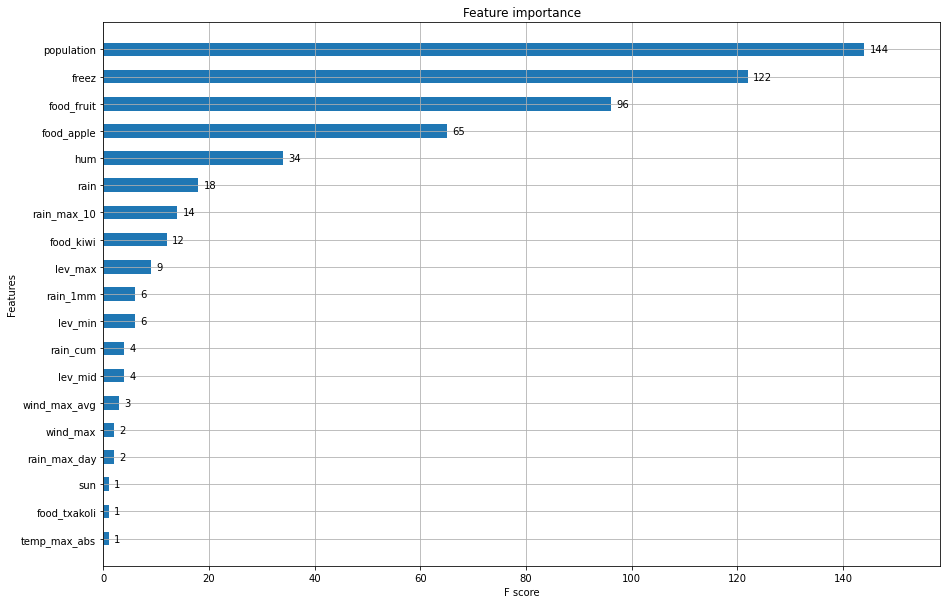

In [482]:
# plot feature importance to select relevant variables

plot_importance(model_cluster3,height=0.5)
plt.show()

In [483]:
# selecting the XGBoost model and fitting with the train data without the irrelevant variables
# selecting the train X & y variables

# Y will be the response variable (filter for the number of wasp nests - waspbust_id)  
y_cluster3 = queen_train_cluster3.waspbust_id

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X_cluster3 = queen_train_cluster3.iloc[:,6:].loc[:,["population","food_fruit","freez"]]

# We want to predict our response variable (number of nests in 2020). Remove response variable and non desired categorical columns such as (municip code, year, etc...)
queen_predict2020_cluster3 = queen_predict_cluster3.iloc[:,5:].loc[:,["population","food_fruit","freez"]]

### Choose a class of model by importing the appropriate estimator class

In [484]:
# refitting the model

model_cluster3 = XGBRegressor()

### Fit the model to your data by calling the `.fit()` method of the model instance

In [485]:
model_cluster3.fit(X_cluster3, y_cluster3)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Apply the model to new data:

- For supervised learning, predict labels for unknown data using the `.predict()` method

In [486]:
# make a prediction

prediction_2020_cluster3 = model_cluster3.predict(queen_predict2020_cluster3)

C:\Users\pgeir\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [487]:
# the number of nests so we can compare between us
print(prediction_2020_cluster3.sum())

143.70311


## Get the Prediction for: Cluster 4

### Arrange data into a features matrix and target vector

In [539]:
# selecting the train X & y variables

queen_train_cluster4 = queen_train.loc[queen_train.municip_code.isin(queen_cluster_dict.get("queen_cluster4")),:] 
queen_predict_cluster4 = queen_predict.loc[queen_predict.municip_code.isin(queen_cluster_dict.get("queen_cluster4")),:] 

# Y will be the response variable (filter for the number of wasp nests - waspbust_id)  
y_cluster4 = queen_train_cluster4.waspbust_id

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X_cluster4 = queen_train_cluster4.iloc[:,6:].drop("station_code",axis=1)

# We want to predict our response variable (number of nests in 2020). Remove response variable and non desired categorical columns such as (municip code, year, etc...)
queen_predict2020_cluster4 = queen_predict_cluster4.iloc[:,5:].drop("station_code",axis=1)

### Scale the Data in order to filter the relevant variables using Feature Importance

#### Arrange data into a features matrix and target vector

In [489]:
# Scale the datasets using MinMaxScaler

X_scaled_cluster4 = preprocessing.minmax_scale(X_cluster4) # this creates a numpy array
X_scaled_cluster4 = pd.DataFrame(X_scaled_cluster4,index=X_cluster4.index,columns=X_cluster4.columns) # create a Pandas DF==X

#### Choose a class of model by importing the appropriate estimator class

In [490]:
# selecting the XGBoost model and fitting with the train data
model_cluster4 = XGBRegressor()

#### Fit the model to your data by calling the `.fit()` method of the model instance

In [491]:
model_cluster4.fit(X_scaled_cluster4, y_cluster4)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Selecting the Relevant Variables and filtering according to the results

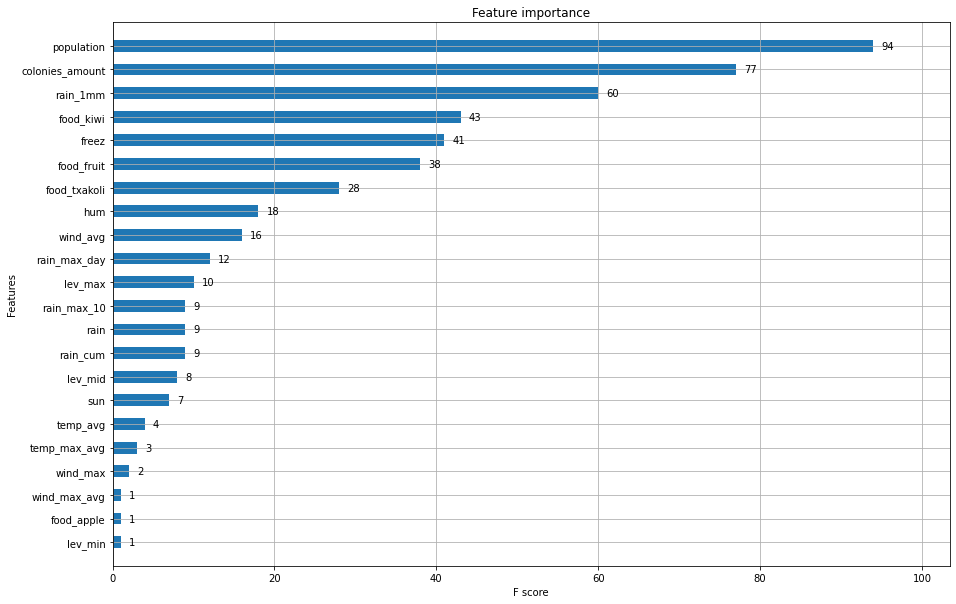

In [492]:
# plot feature importance to select relevant variables

plot_importance(model_cluster4,height=0.5)
plt.show()

In [493]:
# selecting the XGBoost model and fitting with the train data without the irrelevant variables
# selecting the train X & y variables

# Y will be the response variable (filter for the number of wasp nests - waspbust_id)  
y_cluster4 = queen_train_cluster4.waspbust_id

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X_cluster4 = queen_train_cluster4.iloc[:,6:].loc[:,["population","colonies_amount","rain_1mm"]]

# We want to predict our response variable (number of nests in 2020). Remove response variable and non desired categorical columns such as (municip code, year, etc...)
queen_predict2020_cluster4 = queen_predict_cluster4.iloc[:,5:].loc[:,["population","colonies_amount","rain_1mm"]]

### Choose a class of model by importing the appropriate estimator class

In [494]:
# refitting the model

model_cluster4 = XGBRegressor()

### Fit the model to your data by calling the `.fit()` method of the model instance

In [495]:
model_cluster4.fit(X_cluster4, y_cluster4)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Apply the model to new data:

- For supervised learning, predict labels for unknown data using the `.predict()` method

In [496]:
# make a prediction

prediction_2020_cluster4 = model_cluster4.predict(queen_predict2020_cluster4)

C:\Users\pgeir\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [497]:
# the number of nests so we can compare between us
print(prediction_2020_cluster4.sum())

84.44812


## Add Each Cluster Predictions to the original DataFrame and Save it as a `.csv file`

In [498]:
# Create a new Column with the 2020 prediction
queen_predict["nests_2020"] = 0

In [552]:
predictions_dict = {1:prediction_2020_cluster1,
                    2:prediction_2020_cluster2,
                    3:prediction_2020_cluster3,
                    4:prediction_2020_cluster4}

for i in range(1,5,1):
    queen_predict.loc[queen_predict.municip_code.isin(queen_cluster_dict.get("queen_cluster{0}".format(i))),"nests_2020"] = predictions_dict.get(i)

In [511]:
# Create a new DataFrame with the Municipalities to insert manualy

HEX_aux = pd.DataFrame({"CODIGO MUNICIPIO":[48022, 48071, 48088, 48074, 48051, 48020],\
             "NOMBRE MUNICIPIO":["Karrantza Harana/Valle de Carranza","Muskiz","Ubide","Urduña/Orduña","Lanestosa","Bilbao"],\
             "NIDOS 2020":[0,0,0,0,0,0]})

In [512]:
HEX = queen_predict.loc[:,["municip_code","municip_name","nests_2020"]].round() # create a new Dataframe for Kopuru submission
HEX.columns = ["CODIGO MUNICIPIO","NOMBRE MUNICIPIO","NIDOS 2020"] # change column names to Spanish (Decidata template)
HEX = HEX.append(HEX_aux, ignore_index=True) # Add rows of municipalities to add manually

In [513]:
# Final check

check_data(HEX)

Submission form Shape is (112, 3)
Number of Municipalities is 112
The Total 2020 Nests' Prediction is 2934


'All Municipality Names and Codes to be submitted match the Template'

In [514]:
pd.reset_option("max_rows")

In [507]:
# Save the new dataFrame as a .csv in the current working directory on Windows

HEX.to_csv("WaspBusters_20210519_batch_XGyears.csv", index=False, encoding="latin-1")